In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Const & Inputs

Here are all of the parameters to change for the run.


In [58]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
# path = "/content/drive/MyDrive/Colab Notebooks/aidea-badminton-vision/src"
# path = "../"
path = "aidea-badminton-vision/src"

# Folder of the training data
train_folder = F'{path}/data/train'

# Folder of the validation data
valid_folder = F'{path}/data/valid'

# Image size for model
image_size = 224

# Data size for training
train_size = 10

# The number of combined sheets of Mixup
mixup_sheet = 3

# Get the shape of the input layer
input_shape = (image_size, image_size, 3)

## Import Packages

In [59]:
import sys
sys.path.append(path)

In [60]:
import cv2
import os
import time
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [61]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.11.0


In [62]:
from utils.model import get_reducelr, get_checkpoint, get_early_stop

## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [63]:
SEED = 5397
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [64]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Not connected to a TPU runtime. Using CPU/GPU strategy
Found GPU at: /device:GPU:0
Thu Mar 30 14:19:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090         On | 00000000:01:00.0 Off |                  Off |
|  0%   42C    P8               27W / 450W|  23989MiB / 24564MiB |      0%      Default |
|                                         |                      |         

## Data Preprocessing

Include: laod data, encode categorical features, split data, normalize data, and save data.


In [65]:
def get_image_crop_by_center(image):
    h, w = image.shape[:2]
    if h > w:
        return image[(h-w)//2:(h-w)//2+w, :, :]
    else:
        return image[:, (w-h)//2:(w-h)//2+h, :]
    
def read_video_to_frames(video_path, new_size=(image_size, image_size), resize_method="crop"):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = get_image_crop_by_center(frame) if resize_method == "crop" else frame
            frame = cv2.resize(frame, new_size, interpolation=cv2.INTER_AREA)
            frames.append(frame)
        else:
            break
    cap.release()
    return pd.DataFrame({"Frame": list(range(0, len(frames))), "Vector": frames})

def go_through_folders_to_get_video_information(path, limit=None, verbose=0):
    dataframes = []
    for idx, folder in enumerate(os.listdir(path)[:limit]):
        if(verbose):
            print(F'{idx+1}/{len(os.listdir(path)[:limit])}, folder: {folder}')
        info = None
        frames = None
        for file in os.listdir(os.path.join(path, folder)):
            if file.endswith("csv"):
                csv_path = os.path.join(path, folder, file)
                info = pd.read_csv(csv_path)
                info = info.assign(VideoName=folder)
            elif file.endswith("mp4"):
                video_path = os.path.join(path, folder, file)
                frames = read_video_to_frames(video_path)
                frames = frames.assign(VideoName=folder)
        dataframes.append(pd.merge(frames, info, left_on=["VideoName", "Frame"], right_on=["VideoName", "HitFrame"], how="left"))
    return pd.concat(dataframes, ignore_index=True)

In [66]:
def get_sliding_samples_by_video(df, window_size=10):
    idxs, xx, yy = [], [], []
    for video in df["VideoName"].unique():
        video_df = df[df["VideoName"] == video].reset_index(drop=True)
        for i in range(0, len(video_df)-window_size+1):
            x = video_df.loc[i:i+window_size-1, "Vector"]
            y = video_df.loc[i:i+window_size-1, "IsHitFrame"]
            idxs.extend([{'VideoName': video, 'Frame': video_df.loc[i+j, "Frame"]} for j in range(window_size)])
            xx.append(x.tolist())
            yy.append(y.astype(int).tolist())
    return pd.DataFrame(idxs), np.array(xx), np.array(yy)

def get_mixup_samples_by_video(df, sheets=3, interval=2):
    '''
    sheets: The number of frames contained in each mixup group, sheets must be an even number.
    
    interval: The interval between two mixup centers.
    '''
    sheets = sheets // 2 * 2 + 1
    idxs, xx, yy = [], [], []
    for video in df["VideoName"].unique():
        video_df = df[df["VideoName"] == video].reset_index(drop=True)
        for i in range(max(interval, sheets//2+1)-1, len(video_df), interval+1):
            x = video_df.loc[i-sheets//2:i+sheets//2, "Vector"].tolist()
            x = np.mean(x, axis=0).astype(np.uint8)
            y = video_df.loc[i-sheets//2:i+sheets//2, "IsHitFrame"].tolist()
            y = np.max(y).astype(np.uint8)
            # idxs.extend([{'VideoName': video, 'Frame': video_df.loc[i+j, "Frame"]} for j in range(i-sheets//2, i+sheets//2)])
            idxs.append({'VideoName': video, 'Frame': video_df.loc[i-sheets//2:i+sheets//2, "Frame"].tolist()})
            xx.append(x.tolist())
            yy.append(y.astype(int).tolist())
    return pd.DataFrame(idxs), np.array(xx), np.array(yy)

In [67]:
train = go_through_folders_to_get_video_information(train_folder, limit=train_size, verbose=0)
pd.to_pickle(train, F"{path}/data/train_i{image_size}_s{train_size}.pkl", protocol=4)
valid = go_through_folders_to_get_video_information(valid_folder, limit=train_size//8, verbose=0)
pd.to_pickle(valid, F"{path}/data/valid_i{image_size}_s{train_size//8}.pkl", protocol=4)

In [ ]:
# train = pd.read_pickle(F"{path}/data/train_i{image_size}_s{train_size}.pkl")
# valid = pd.read_pickle(F"{path}/data/valid_i{image_size}_s{train_size//8}.pkl")

In [68]:
train['IsHitFrame'] = train['HitFrame'].apply(lambda x: 1 if x > 0 else 0)
valid['IsHitFrame'] = valid['HitFrame'].apply(lambda x: 1 if x > 0 else 0)

MixUp x5

In [46]:
idxs, xx, yy = get_mixup_samples_by_video(train, sheets=5)

1077


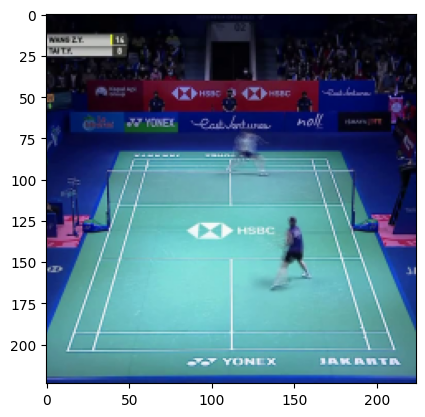

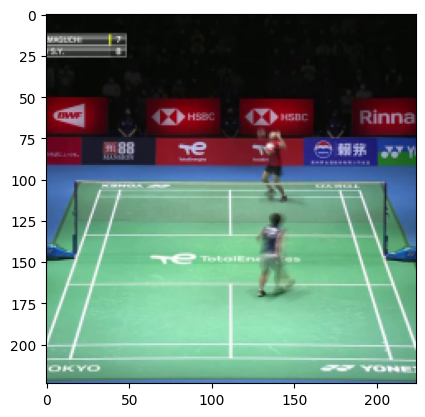

In [38]:
print(len(xx))
plt.imshow(xx[50])
plt.show()
plt.imshow(xx[320])
plt.show()

Sliding Samples

In [16]:
train_idx, train_x, train_y = get_sliding_samples_by_video(train, window_size=8)
valid_idx, valid_x, valid_y = get_sliding_samples_by_video(valid, window_size=8)

Oversampling

In [ ]:
positive_cases = np.argwhere(np.sum(train_y, axis=1) > 0).reshape(-1)
print(F"Positive Rate: {round(len(positive_cases)/len(train_y), 2)}")
oversampling_rate = (len(train_y)-len(positive_cases))//len(positive_cases)
print(F"Oversampling Rate: {oversampling_rate}")

In [ ]:
train_x = np.concatenate([train_x, np.repeat(train_x[positive_cases], oversampling_rate, axis=0)], axis=0)
train_y = np.concatenate([train_y, np.repeat(train_y[positive_cases], oversampling_rate, axis=0)], axis=0)

In [17]:
print("train_x.shape", train_x.shape, "train_y.shape", train_y.shape)
print("valid_x.shape", valid_x.shape, "valid_y.shape", valid_y.shape)

train_x.shape (1731, 8, 224, 224, 3) train_y.shape (1731, 8)
valid_x.shape (2125, 8, 224, 224, 3) valid_y.shape (2125, 8)


## Modelling & Training

In [18]:
def get_batch_dataset(train_vector, train_class, valid_vector, valid_class, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((train_vector, train_class)).shuffle(5000, seed=5397).batch(batch_size, drop_remainder=True)
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_vector, valid_class)).batch(batch_size, drop_remainder=True)
    return train_ds, valid_ds

In [27]:
def get_n2n_convlstm2d_model(input_shape, learning_rate=5e-04, dropout_rate=0.2, isAugmentationActivated=False):
    model = tf.keras.models.Sequential([
        tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), input_shape=(None, *input_shape), padding='same', return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(dropout_rate)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')], run_eagerly=False)
    return model

In [ ]:
# [10, 30, 50, 100, 150]
EPOCHS = 10

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 1 * strategy.num_replicas_in_sync

# learning rate
LR_START = 5e-04

# dropout rate
DROPOUT = 0.2

# Define model name
model_name = F'convlstm2d_data{train_size}_oversampling_i{image_size}_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_reducelr_dropout{int(DROPOUT*100)}'

# Check model is exist, stop training if model is exist
if os.path.exists(F'{path}/models/{model_name}.h5'):
    raise SystemExit(F'{model_name} is exist')

In [21]:
# Dataset to train
train_ds, valid_ds = get_batch_dataset(train_x, train_y, valid_x, valid_y, BATCH_SIZE)

In [20]:
with strategy.scope():    
    model = get_n2n_convlstm2d_model(input_shape, LR_START, DROPOUT, isAugmentationActivated=False)
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
start = time.time()

# Train model
history = model.fit(
    train_ds, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=valid_ds, 
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0), 
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False), 
        tf.keras.callbacks.ModelCheckpoint(F'{path}/models/{model_name}.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
    ]
)

# Save history
history = pd.DataFrame(history.history)
history.to_csv(F'{path}/logs/{model_name}.csv', index=False)

end = time.time()
print(format(end-start))

Epoch 1/100
1731/1731 [==============================] - ETA: 0s - loss: 0.4291 - binary_accuracy: 0.9721 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.49360, saving model to ..//models/224_convlstm2d_epochs100_batchsize1_lr0.0005_reducelr_dropout40.h5
1731/1731 [==============================] - 363s 207ms/step - loss: 0.4291 - binary_accuracy: 0.9721 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.4936 - val_binary_accuracy: 0.9680 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/100
 450/1731 [======>.......................] - ETA: 3:18 - loss: 0.3728 - binary_accuracy: 0.9758 - recall: 0.0000e+00 - precision: 0.0000e+00

epochs:  10


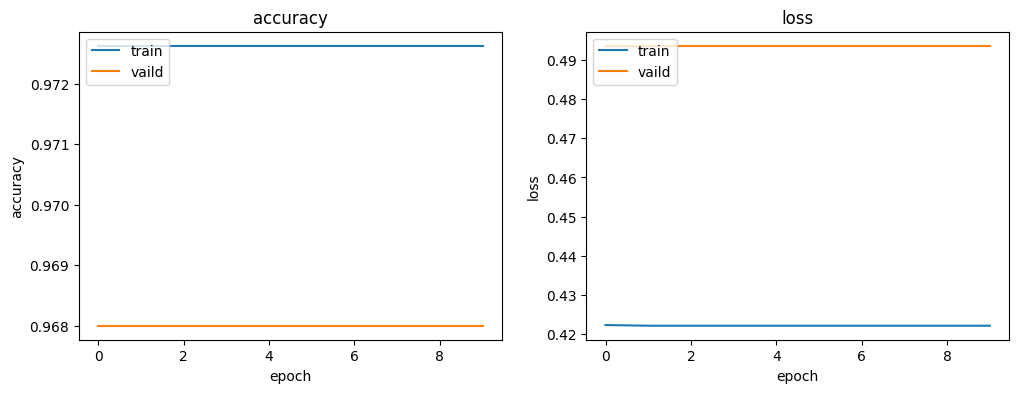

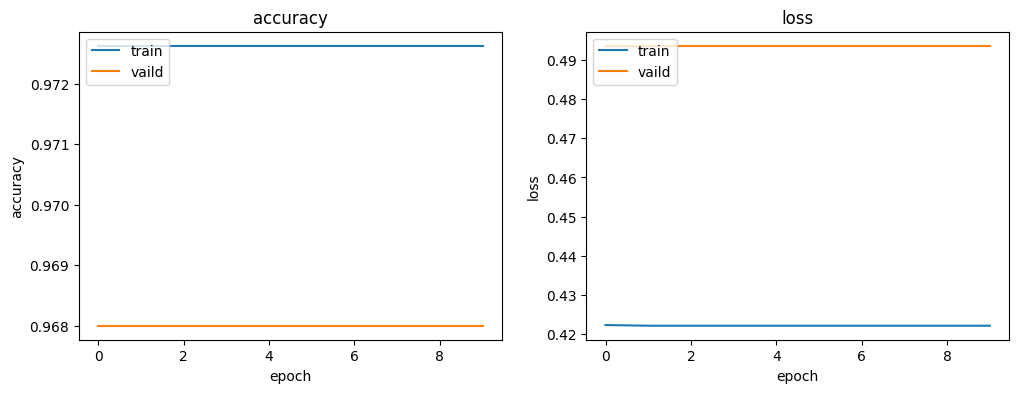

In [25]:
log = pd.read_csv(F'{path}/logs/{model_name}.csv')
print('epochs: ',len(log))
plt.figure(figsize=(12, 4))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(log['binary_accuracy'])
plt.plot(log['val_binary_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(log['loss']) 
plt.plot(log['val_loss']) 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Save image
plt.show()
plt.savefig(F'{path}/logs/{model_name}.jpg')

### Prediction of vaild
Prediction based on the best model during training

In [28]:
# Load model with the best validation accuracy
with strategy.scope():    
    model = get_n2n_convlstm2d_model(input_shape, LR_START, DROPOUT, isAugmentationActivated=False)
    model.load_weights(F'{path}/models/{model_name}.h5')

In [ ]:
# Predict the response for train dataset
# train_idx['PredIsHitFrame'] = model.predict(train_x, verbose=1).reshape(-1)
valid_idx['PredIsHitFrame'] = model.predict(valid_x, verbose=1).reshape(-1)
# train_idx_group = train_idx.groupby(['VideoName', 'Frame']).mean().reset_index()
valid_idx_group = valid_idx.groupby(['VideoName', 'Frame']).mean().reset_index()

In [33]:
# train = pd.merge(train, train_idx_group, on=['VideoName', 'Frame'], how='left')
valid = pd.merge(valid, valid_idx_group, on=['VideoName', 'Frame'], how='left')

In [ ]:
# train.to_pickle(F'{path}/outputs/train/{model_name}.pkl', protocol=4)
valid.to_pickle(F'{path}/outputs/valid/{model_name}.pkl', protocol=4)